In [14]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import timedelta
from PIL import Image

import scipy.misc

from keras.preprocessing.image import load_img, img_to_array, array_to_img
import tensorflow as tf

In [15]:
 # ファイル数を調べたいフォルダのパス
img_path = "./adidas_img" 
 
# フォルダ内の全ファイル名をリスト化
img_files = os.listdir(img_path)
 
# リストの長さ（ファイル数）を取得
img_count = len(img_files)

img_count

5348

In [16]:
img_id_list = []
for img in img_files:
    img = img.split('.')
    id = img[0]
    img_id_list.append(id)
    
img_id_list

['adidas-0-to-60-stmt-pharrell-multicolor',
 'adidas-18-fg-red-silver-blue',
 'adidas-350-black-orange-yellow',
 'adidas-350-oyster-holdings-ash-pearl',
 'adidas-350-oyster-holdings-green-ff',
 'adidas-350-oyster-holdings-trace-scarlet',
 'adidas-350-white-scarlet-orange',
 'adidas-3d-runner-black',
 'adidas-3mc-beavis-and-butthead',
 'adidas-3mc-disney-sport-goofy',
 'adidas-3mc-slip-disney-sport-goofy',
 'adidas-3mc-vulc-beavis-and-butthead',
 'adidas-3mc-vulc-cloud-white',
 'adidas-3mc-vulc-collegiate-navy',
 'adidas-3mc-vulc-core-black-cloud-white',
 'adidas-3mc-vulc-daewon-song-collegiate-navy',
 'adidas-3mc-vulc-evisen',
 'adidas-3mc-vulc-light-solid-grey',
 'adidas-3mc-vulc-raw-khaki',
 'adidas-3st-001-grey-black',
 'adidas-3st-002-bape',
 'adidas-3st-002-clear-brown',
 'adidas-3st-002-collegiate-navy',
 'adidas-3st-003-clear-brown',
 'adidas-3st-003-clear-onix',
 'adidas-3st-003-core-black',
 'adidas-3st-003-miles-silvas',
 'adidas-3st-003-na-kel-smith',
 'adidas-3st-004-cloud-

In [17]:
#dfの列を50まで省略せずに表示
pd.set_option('display.max_columns', 50)

#ユニークな要素のみ抽出
adidas_detail = pd.read_csv('adidas_detail.csv')
adidas_detail_unique = adidas_detail[~adidas_detail['id'].duplicated()]
adidas_detail_unique = adidas_detail_unique.reset_index()
adidas_detail_unique = adidas_detail_unique.drop(adidas_detail_unique.columns[[0, 1]], axis=1)

#'--'をNaNに置換
adidas_detail_unique = adidas_detail_unique.replace('--', math.nan)

#'\'を削除
adidas_detail_unique['last_sale'] = adidas_detail_unique['last_sale'].str[1:]
adidas_detail_unique['lowest_ask'] = adidas_detail_unique['lowest_ask'].str[1:]
adidas_detail_unique['highest_bid'] = adidas_detail_unique['highest_bid'].str[1:]

#'7,600'→'7600'
adidas_detail_unique['avg_sale_price_12_month'] = adidas_detail_unique[
    'avg_sale_price_12_month'].str.replace(',', '')

#数値の欠損値を0埋め
adidas_detail_unique[['last_sale', 'last_sale_size', 'lowest_ask', 'highest_bid', 
                      'retail_price', 'high_52_week', 'low_52_week', 'low_12_month_trade', 
                      'high_12_month_trade', 'volatility','num_sales_12_month', 
                      'price_premium_12_month', 'avg_sale_price_12_month']] = adidas_detail_unique[[
                      'last_sale', 'last_sale_size', 'lowest_ask', 'highest_bid', 
                      'retail_price', 'high_52_week', 'low_52_week', 'low_12_month_trade', 
                      'high_12_month_trade', 'volatility','num_sales_12_month', 
                      'price_premium_12_month', 'avg_sale_price_12_month']].fillna(0)

#intに変換
adidas_detail_unique[['last_sale', 'lowest_ask', 'highest_bid', 'retail_price', 'high_52_week', 
                      'low_52_week', 'low_12_month_trade', 'high_12_month_trade', 
                      'num_sales_12_month', 'avg_sale_price_12_month']] = adidas_detail_unique[[
                      'last_sale', 'lowest_ask', 'highest_bid', 'retail_price', 'high_52_week', 
                      'low_52_week', 'low_12_month_trade', 'high_12_month_trade', 
                      'num_sales_12_month', 'avg_sale_price_12_month']].astype(int)

#floatに変換
#'last_sale_size', 
adidas_detail_unique[['volatility', 'price_premium_12_month']] = adidas_detail_unique[[
    'volatility', 'price_premium_12_month']].astype(float)

#日付に変換
adidas_detail_unique['release_date'] = pd.to_datetime(adidas_detail_unique['release_date'], format='%m/%d/%Y')

#0埋めした欠損値を欠損値NaNに戻す
adidas_detail_unique = adidas_detail_unique.replace(0, math.nan)
adidas_detail_unique[['since_last_sale_dollar', 'since_last_sale_percent']] = adidas_detail_unique[[
    'since_last_sale_dollar', 'since_last_sale_percent']].fillna(0)

#目的変数avg_sale_price_12_monthに欠損値をもつものを消去
adidas_detail_unique = adidas_detail_unique.dropna(subset=['avg_sale_price_12_month'])

#retail_priceに欠損値をもつものを消去
adidas_detail_unique = adidas_detail_unique.dropna(subset=['retail_price'])

#'volatility', 'release_date'に欠損値をもつものを消去
# adidas_detail_unique = adidas_detail_unique.dropna(subset=['volatility', 'release_date'])

#発売後の日数を追加(スクレイプ日2020年10月18日との差)
adidas_detail_unique['period'] = pd.to_datetime('20201018') - adidas_detail_unique['release_date']

#timedelta型から整数型に変換
adidas_detail_unique['period'] = adidas_detail_unique['period'] / timedelta(days=1)
adidas_detail_unique

#モデル名追加
model_name = adidas_detail_unique['product_name'].str.split(expand=True)
adidas_detail_unique['model'] = model_name.iloc[:, 1]
adidas_detail_unique

,id,brand,product_name,condition,last_sale,last_sale_size,lowest_ask,highest_bid,since_last_sale_dollar,since_last_sale_percent,colorway,retail_price,release_date,high_52_week,low_52_week,low_12_month_trade,high_12_month_trade,volatility,num_sales_12_month,price_premium_12_month,avg_sale_price_12_month,period,model
0,adidas-dame-5-core-black-shock-pink,adidas,adidas dame 5 core black shock pink,New,6400.0,10.5,6600.0,6300.0,500.0,7.0,Core Black/Core Black/Shock Pink,115.0,2019-07-01,16300.0,4100.0,4700.0,8100.0,26.9,174.0,-47.8,7600.0,475.0,dame
1,adidas-n3xt-l3v3l-cream-white-bahia-light-blue,adidas,adidas n3xt l3v3l cream white bahia light blue,New,10500.0,11.5,7800.0,11600.0,400.0,3.0,Cream White/Footwear White/Bahia Light Blue,180.0,2019-05-03,26600.0,6700.0,8400.0,12600.0,19.9,172.0,-45.0,11900.0,534.0,n3xt
2,adidas-don-issue-1-amazing-spider-man,adidas,adidas d.o.n. issue #1 amazing spider man,New,11000.0,12.5,9300.0,10000.0,-200.0,-2.0,Scarlet/Cloud White/Collegiate Royal,100.0,2019-07-01,21100.0,5800.0,9100.0,12900.0,16.9,469.0,4.0,11000.0,475.0,d.o.n.
3,adidas-dame-5-marvel-black-panther,adidas,adidas dame 5 marvel black panther,New,20600.0,11.5,10700.0,22700.0,6900.0,50.0,Core Black/Active Purple/Silver Metallic,125.0,2019-04-26,36900.0,4900.0,14800.0,26400.0,28.4,135.0,56.0,17400.0,541.0,dame
4,adidas-harden-ls-2-buckle-triple-black,adidas,adidas harden ls 2 buckle triple black,New,7800.0,10.5,4100.0,4800.0,2200.0,37.0,Core Black/Solid Grey/Core Black,180.0,2018-01-01,10600.0,3400.0,6700.0,9000.0,14.5,126.0,-58.9,6000.0,1021.0,harden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5607,adidas-yeezy-boost-950-pirate-black,adidas,adidas yeezy boost 950 pirate black,New,158100.0,10,68600.0,73700.0,73900.0,88.0,NaN,585.0,2015-10-29,158100.0,52700.0,129400.0,186900.0,18.2,15.0,156.4,89100.0,1816.0,yeezy
5608,adidas-yeezy-boost-380-calcite-glow,adidas,adidas yeezy boost 380 calcite glow,New,48000.0,10.5,39600.0,34200.0,19000.0,65.0,Calcite/Calcite/Calcite,230.0,NaT,48000.0,29000.0,41500.0,54500.0,13.7,5.0,97.8,35600.0,NaN,yeezy
5614,adidas-yeezy-boost-950-peyote,adidas,adidas yeezy boost 950 peyote,New,79200.0,9,84400.0,79200.0,21200.0,37.0,NaN,585.0,2015-10-29,79200.0,40100.0,67400.0,91000.0,15.0,8.0,28.4,55800.0,1816.0,yeezy
5615,adidas-yeezy-500-shadow-black-ff,adidas,adidas yeezy 500 shadow black (friends & family),New,38800.0,10,52200.0,52600.0,0.0,0.0,Shadow Black/Shadow Black/Shadow Black,200.0,2018-07-07,38800.0,38800.0,34900.0,42700.0,NaN,1.0,84.0,38800.0,834.0,yeezy


In [18]:
#id列を取り出しリストに変換

adidas_detail_list = adidas_detail_unique['id'].values.tolist()

In [19]:
#画像、テーブルデータの両方もつものを抽出

img_table_and = set(img_id_list) & set(adidas_detail_list)
len(img_table_and)

3857

In [20]:
img_table_and

{'adidas-nmd-hu-china-pack-happy-gold',
 'adidas-nmd-xr1-olive-camo',
 'adidas-harden-vol-4-black-green-orange',
 'adidas-eqt-support-adv-white-black',
 'adidas-adizero-prime-olive',
 'adidas-ultra-boost-2020-iss-us-national-lab-dash-grey-blue-violet',
 'adidas-crazy-byw-alphatype',
 'adidas-tubular-shadow-knit-clear-brown',
 'adidas-harden-volpt-3-radioactive-yellow-sole',
 'adidas-top-ten-hi-core-black',
 'adidas-u-path-signal-green-td',
 'adidas-ultra-boost-3pt0-energy',
 'adidas-nmd-cs2-sns-class-of-99-burgundy',
 'adidas-stan-smith-fashion-week',
 'adidas-ultra-boost-uncaged-non-dyed-white',
 'ultraboost-all-terrain-black-red-grey',
 'adidas-x9000l4-core-black-grey-six',
 'adidas-campus-80s-sneakersnstuff-22-little-west',
 'adidas-pulseboost-hd-missoni-raw-white',
 'adidas-stan-smith-cloud-white-blue-glow',
 'adidas-tubular-doom-triple-black',
 'adidas-nmd-racer-whitaker-group',
 'adidas-nmd-r1-black-white-trace-khaki',
 'adidas-nmd-r1-bright-cyan',
 'adidas-pureboost-dpr-hi-res-r

In [21]:
# nplist = np.array(arrlist)
np.save('id_list', img_table_and)

In [9]:
img_table_and_df = pd.DataFrame(img_table_and)
img_table_and_df.columns = ['id']
img_table_and_df

,id
0,adidas-nmd-hu-china-pack-happy-gold
1,adidas-nmd-xr1-olive-camo
2,adidas-harden-vol-4-black-green-orange
3,adidas-eqt-support-adv-white-black
4,adidas-adizero-prime-olive
...,...
3852,adidas-nmd-cs1-lux-core-black
3853,adidas-nmd-r1-black-grey-three
3854,adidas-adilette-slide-huangs-world
3855,adidas-y-3-adilette-black-white


In [22]:
# adidas_final_df = img_table_and_df.join(adidas_detail_unique)
adidas_final_df = pd.merge(img_table_and_df, adidas_detail_unique, on='id')
adidas_final_df['retail_price'] = adidas_final_df['retail_price'] *104.7
adidas_final_df['retail_price']
adidas_final_df

,id,brand,product_name,condition,last_sale,last_sale_size,lowest_ask,highest_bid,since_last_sale_dollar,since_last_sale_percent,colorway,retail_price,release_date,high_52_week,low_52_week,low_12_month_trade,high_12_month_trade,volatility,num_sales_12_month,price_premium_12_month,avg_sale_price_12_month,period,model
0,adidas-nmd-hu-china-pack-happy-gold,adidas,adidas pharrell nmd hu china pack happy (gold)...,New,396800.0,7.5,632400.0,526900.0,0.0,0.0,Gold/White,26175.0,2018-05-12,396800.0,396800.0,357100.0,436400.0,NaN,1.0,1405.6,396800.0,890.0,pharrell
1,adidas-nmd-xr1-olive-camo,adidas,adidas nmd xr1 olive duck camo,New,14900.0,11.5,15900.0,14700.0,4300.0,41.0,NaN,15705.0,2016-11-25,29800.0,8000.0,10300.0,19400.0,31.2,75.0,-6.3,18100.0,1423.0,nmd
2,adidas-harden-vol-4-black-green-orange,adidas,adidas harden vol. 4 black green orange,New,9400.0,11.5,7500.0,7000.0,0.0,0.0,Core Black/Amber Tint/Glory Purple,13611.0,2020-05-08,9400.0,7100.0,8400.0,10500.0,10.7,4.0,-31.5,8900.0,163.0,harden
3,adidas-eqt-support-adv-white-black,adidas,adidas eqt support adv white black,New,9500.0,12,12700.0,11400.0,-6200.0,-40.0,NaN,11517.0,2016-12-03,16900.0,9500.0,7300.0,11700.0,23.0,7.0,-18.2,13600.0,1415.0,eqt
4,adidas-adizero-prime-olive,adidas,adidas adizero prime olive,New,13000.0,10.5,10100.0,NaN,0.0,0.0,NaN,18846.0,2016-12-28,13000.0,13000.0,11700.0,14300.0,NaN,1.0,-31.7,13000.0,1390.0,adizero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3852,adidas-nmd-cs1-lux-core-black,adidas,adidas nmd cs1 lux core black,New,14700.0,6.5,10600.0,12300.0,-3700.0,-20.0,Core Black/Core Black/Cloud White,18846.0,2018-07-01,23300.0,6200.0,12100.0,17300.0,17.9,69.0,-22.7,13100.0,840.0,nmd
3853,adidas-nmd-r1-black-grey-three,adidas,adidas nmd r1 black grey three,New,5800.0,12,11600.0,8400.0,-7300.0,-56.0,Core Black/Core Black/Grey Three,17799.0,2019-07-01,21100.0,5800.0,3400.0,8300.0,42.2,100.0,-67.6,10800.0,475.0,nmd
3854,adidas-adilette-slide-huangs-world,adidas,adidas adilette huangs world,New,13200.0,12,20600.0,13700.0,2700.0,25.0,NaN,5235.0,2016-10-08,13200.0,8500.0,11700.0,14700.0,11.2,6.0,150.0,10700.0,1471.0,adilette
3855,adidas-y-3-adilette-black-white,adidas,adidas y-3 adilette black white,New,12200.0,7,13800.0,4200.0,0.0,0.0,Black/Footwear White,13611.0,2019-01-01,12200.0,12200.0,11000.0,13400.0,NaN,1.0,-11.5,12200.0,656.0,y-3


In [23]:
adidas_final_df.to_csv('adidas_final_df.csv')

In [24]:
img_table_and_df.to_csv('img_table_and_df.csv')

今回扱うデータは3857個

In [25]:
img_list = []
for img in img_table_and:
    img = img + '.jpg'
    img_list.append(img)

In [26]:
img_list

['adidas-nmd-hu-china-pack-happy-gold.jpg',
 'adidas-nmd-xr1-olive-camo.jpg',
 'adidas-harden-vol-4-black-green-orange.jpg',
 'adidas-eqt-support-adv-white-black.jpg',
 'adidas-adizero-prime-olive.jpg',
 'adidas-ultra-boost-2020-iss-us-national-lab-dash-grey-blue-violet.jpg',
 'adidas-crazy-byw-alphatype.jpg',
 'adidas-tubular-shadow-knit-clear-brown.jpg',
 'adidas-harden-volpt-3-radioactive-yellow-sole.jpg',
 'adidas-top-ten-hi-core-black.jpg',
 'adidas-u-path-signal-green-td.jpg',
 'adidas-ultra-boost-3pt0-energy.jpg',
 'adidas-nmd-cs2-sns-class-of-99-burgundy.jpg',
 'adidas-stan-smith-fashion-week.jpg',
 'adidas-ultra-boost-uncaged-non-dyed-white.jpg',
 'ultraboost-all-terrain-black-red-grey.jpg',
 'adidas-x9000l4-core-black-grey-six.jpg',
 'adidas-campus-80s-sneakersnstuff-22-little-west.jpg',
 'adidas-pulseboost-hd-missoni-raw-white.jpg',
 'adidas-stan-smith-cloud-white-blue-glow.jpg',
 'adidas-tubular-doom-triple-black.jpg',
 'adidas-nmd-racer-whitaker-group.jpg',
 'adidas-nmd-r1

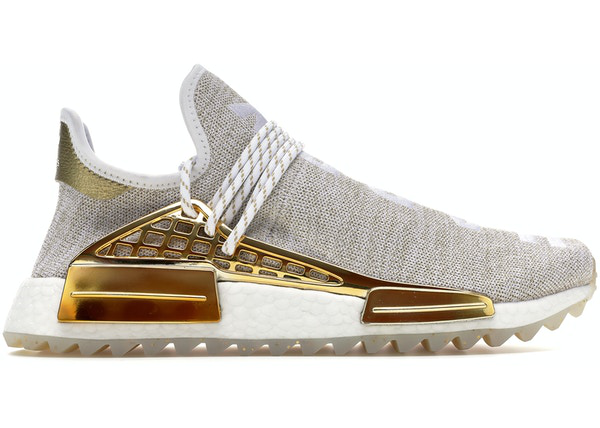

In [27]:
path = img_path + '/' + img_list[0]
img = Image.open(path)
img

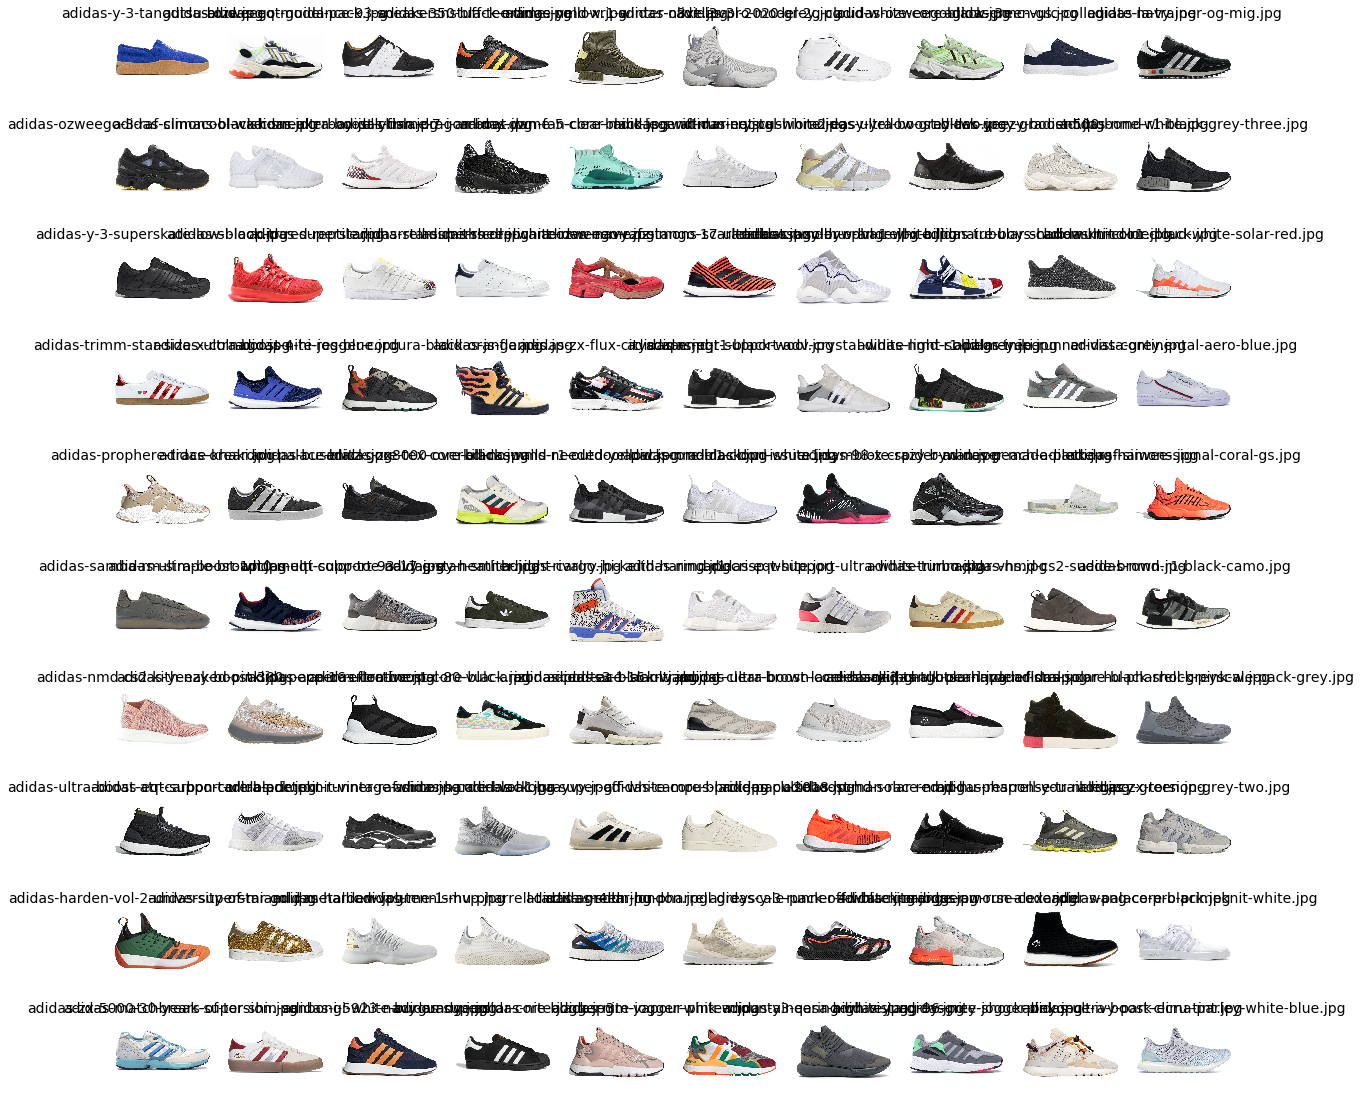

In [23]:
# 画像表示
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    path = img_path + '/' + img_list[i]
    img = Image.open(path)
    im_list = np.asarray(img)
    plt.imshow(im_list)
    plt.axis('off')
    plt.title(str(img_list[i]),fontsize=14)
#     plt.savefig('./cifar10.png', bbox_inches='tight')
plt.show()

In [34]:
hw = {'height': 16, 'width': 16}
# hw = {'height': 64, 'width': 64}
# hw = {'height': 128, 'width': 128}
# hw = {'height': 256, 'width': 256}


arrlist = []

for img_name in img_list:
    path = img_path + '/' + img_name
    img = load_img(path, target_size = (hw['height'], hw['width']))
    array = img_to_array(img) / 255
    arrlist.append(array)

In [36]:
# path = img_path + '/' + img_name
# img = scipy.misc.imread('')

In [ ]:
# arrlist

In [ ]:
# len(arrlist)

In [35]:
nplist = np.array(arrlist)
np.save('img_features16', nplist)

In [31]:
path = img_path + '/' + img_list[0]

img_raw = tf.io.read_file(path)
img = tf.image.decode_jpeg(img_raw)
img.shape

TensorShape([Dimension(None), Dimension(None), Dimension(None)])

In [ ]:
path = img_path + '/' + img_list[0]
img = Image.open(path)
img